### Final Project

In [8]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.datasets import get_rdataset
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, LassoCV, LogisticRegression
from sklearn.preprocessing import LabelBinarizer, StandardScaler
from sklearn.metrics import mean_absolute_error, accuracy_score, confusion_matrix
from ISLP import load_data
from sklearn.cluster import \
     (KMeans,
      AgglomerativeClustering)
from scipy.cluster.hierarchy import \
     (dendrogram,
      cut_tree)
from ISLP.cluster import compute_linkage

np.random.seed(2)
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree, DecisionTreeRegressor

In [3]:
# Load the dataset
#phishingurl_data = pd.read_csv("PhiUSIIL_Phishing_URL_Dataset.csv")
phishingurl_data = pd.read_csv("C:\\Users\\david\\Downloads\\phiusiil+phishing+url+dataset\\PhiUSIIL_Phishing_URL_Dataset.csv")

In [4]:
# There are too many records for these scripts to run in a reasonable amount of time
# So, we take a random sample of 5000 records
url_sample = phishingurl_data.sample(5000, random_state=13)

# Set index equal to the domain field
url_sample.set_index('URL', inplace=True)

# Drop text fields: Filename, URL, TLD, Title
url_sample_data = url_sample.drop(['FILENAME', 'Domain', 'TLD', 'Title'],axis = 1)

In [5]:
url_sample_data = url_sample[['URLLength', 'NoOfLettersInURL', 'NoOfDegitsInURL', 'NoOfEqualsInURL', 'NoOfQMarkInURL', 'NoOfAmpersandInURL', 'NoOfOtherSpecialCharsInURL', 'label']]
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(url_sample_data.drop('label',axis = 1)
                                                    , url_sample_data['label']
                                                    , test_size=0.3, random_state=13)

### Linear Logistic Regression

In [6]:
# Fit linear regression model on train set
model = LogisticRegression(solver='liblinear', random_state=0)
lfit = model.fit(X_train, y_train)

# Predict on test set and calculate accuracy
lpred = lfit.predict(X_test)
acc_score = accuracy_score(lpred , y_test)

print("Accuracy: ",acc_score)

Accuracy:  0.908


### Decision Trees

In [9]:
# fit decision tree model
tree_phishing = DecisionTreeClassifier()
tree_phishing.fit(X_train, y_train)

DecisionTreeClassifier()

In [10]:
tree_summary = export_text(tree_phishing, feature_names=X_train.columns.tolist())
print(tree_summary)

|--- NoOfOtherSpecialCharsInURL <= 2.50
|   |--- NoOfDegitsInURL <= 0.50
|   |   |--- NoOfOtherSpecialCharsInURL <= 1.50
|   |   |   |--- URLLength <= 24.50
|   |   |   |   |--- NoOfLettersInURL <= 11.50
|   |   |   |   |   |--- URLLength <= 23.50
|   |   |   |   |   |   |--- NoOfLettersInURL <= 10.50
|   |   |   |   |   |   |   |--- URLLength <= 22.50
|   |   |   |   |   |   |   |   |--- NoOfLettersInURL <= 9.50
|   |   |   |   |   |   |   |   |   |--- URLLength <= 21.50
|   |   |   |   |   |   |   |   |   |   |--- NoOfLettersInURL <= 8.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 12
|   |   |   |   |   |   |   |   |   |   |--- NoOfLettersInURL >  8.50
|   |   |   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |   |--- URLLength >  21.50
|   |   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |   |--- NoOfLettersInURL >  9.50
|   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |

In [11]:
# predict on test data
tree_pred = tree_phishing.predict(X_test)

# create confusion matrix
confusion_matrix = pd.crosstab(index=tree_pred, columns=y_test, rownames=[''])
print(confusion_matrix)

label    0    1
               
0      604   13
1       21  862


In [12]:
(604+862)/(604+13+21+862)

0.9773333333333334

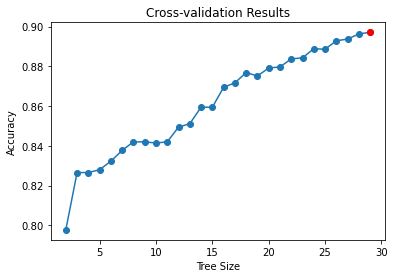

In [16]:
# fit decision tree model
tree_phishing = DecisionTreeClassifier(random_state=7)
tree_phishing.fit(X_train, y_train)

# cross-validation to determine optimal tree size
params = {'max_leaf_nodes': range(2, 30)}  
cv_phishing = GridSearchCV(tree_phishing, params, cv=10)
cv_phishing.fit(X_train, y_train)
cv_results = cv_phishing.cv_results_

# find the best score for max leaf nodes
best_size = cv_phishing.best_params_['max_leaf_nodes']
best_score = cv_phishing.best_score_

# plot results of cross-validation
plt.figure(figsize=(6, 4))
plt.plot(cv_results["param_max_leaf_nodes"], cv_results["mean_test_score"], 'o-')
plt.plot(best_size, best_score, 'ro-')
plt.xlabel('Tree Size')
plt.ylabel('Accuracy')
plt.title('Cross-validation Results');

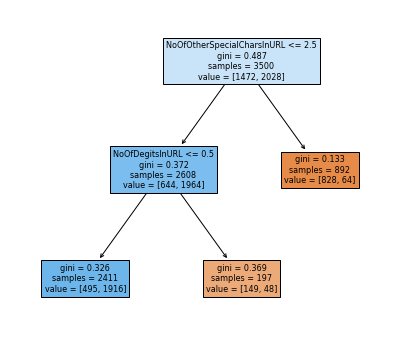

In [23]:
# prune tree using optimal size
prune_phishing = DecisionTreeClassifier(max_leaf_nodes=3, random_state=7)
prune_phishing.fit(X_train, y_train)

# plot pruned tree
plt.figure(figsize=(7,6))
plt.title('Pruned Tree')
plot_tree(prune_phishing, feature_names=X_train.columns, filled=True);

In [24]:
# Calculate the accuracy of the decision tree on the test data
accuracy = prune_phishing.score(X_test, y_test)
print("Accuracy: {:.2f}%".format(accuracy*100))

Accuracy: 83.60%
